# Solve zero pressure gradient viscous 1D momentum problem

$$
\frac{\partial u}{\partial t} + 0 - 0 - \nu \frac{\partial^2 u}{\partial z^2}  = \frac{\partial u_{\infty}}{\partial t}
$$

with boundary conditions

$$
u(z=H) = 0
$$

$$
u(z=0) = 0
$$

In [ ]:
# Gotta find my FFTW_PATH
!export FFTW_PATH=/path/to/your/fftw_prefix 

In [4]:
!sudo pip install dedalus

[sudo] password for suntans: 


In [1]:
import time
import numpy as np
import dedalus.public as de
from dedalus.tools  import post

from dedalus.extras.plot_tools import quad_mesh, pad_limits


import logging
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)


Bad key "backend.qt5" on line 8 in
/home/suntans/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
%matplotlib notebook



In [32]:
# Constants

H = 1. # Depth

nz = 64
nz = 200

nu = 1e-2 

u_top  =0
u_bottom = 0

k_ramp = -1/(2*np.pi)

uniform_diffusion = True
hot_start = True

In [33]:
# CReate the domain

z = de.Chebyshev('z',nz,interval=[0.,H])
domain = de.Domain([z],grid_dtype='float')


In [46]:
# Create the problem
problem = de.IVP(domain, variables=['u', 'uz', 'uzz']) # u and viscous stress
problem.parameters['nu'] = nu
problem.parameters['u_top'] = u_top
problem.parameters['u_bottom'] = u_bottom
problem.parameters['k_ramp'] = k_ramp
problem.parameters['a0'] = 1
T = 2*np.pi
problem.parameters['omega'] = 2*np.pi/T



# Add an acceleration term
#ncc = domain.new_field(name = 'duinf_dt')


# if uniform_diffusion:
#     problem.parameters['K'] = K_0
# else:
#     # Add vertically varying diffusion
#     ncc = domain.new_field(name = 'K')
#     ncc['g'] = (H-z)*K_0
#     problem.parameters['K'] = ncc

problem.add_equation('dt(u) - nu*uzz  = a0*cos(omega*t)')
problem.add_equation('uzz - dz(uz) = 0')
problem.add_equation('uz - dz(u) = 0')

# Add the time varying boundary conditions
problem.add_bc('left(u) = 0')
problem.add_bc('right(uz) = 0')
# else:    
#     problem.add_bc('left(u) = u_top*(1-exp(k_ramp*t))')
#     problem.add_bc('right(u) = u_bottom')

# y = 1-exp(-t)


In [47]:
solver = problem.build_solver(de.timesteppers.RK443)

solver.stop_sim_time = 4*np.pi
solver.stop_wall_time = 1000.
solver.stop_iteration = np.inf
dt = 0.01

# Store data for final plot
# Initial conditions
z = domain.grid(0)
u = solver.state['u']

u.set_scales(1, keep_data=True)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]

start_time = time.time()
while solver.ok:
    solver.step(dt)
    if solver.iteration % 20 == 0:
        #logger.info("Time step {}".format(solver.iteration))
        u.set_scales(1, keep_data=True)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)
        
end_time = time.time()

# Print statistics
logger.info('Total time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %solver.iteration)
logger.info('Average timestep: %f' %(solver.sim_time/solver.iteration))

2019-11-07 15:55:36,205 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s
2019-11-07 15:55:40,051 solvers 0/1 INFO :: Simulation stop time reached.
2019-11-07 15:55:40,053 __main__ 0/1 INFO :: Total time: 3.842908
2019-11-07 15:55:40,053 __main__ 0/1 INFO :: Iterations: 1257
2019-11-07 15:55:40,054 __main__ 0/1 INFO :: Average timestep: 0.010000


In [48]:
u_array = np.array(u_list)
t_array = np.array(t_list)
zmesh, tmesh = quad_mesh(x=z, y=t_array)

delta = np.sqrt(2*nu) # assumes zero freq

zmesh = zmesh/delta

<IPython.core.display.Javascript object>


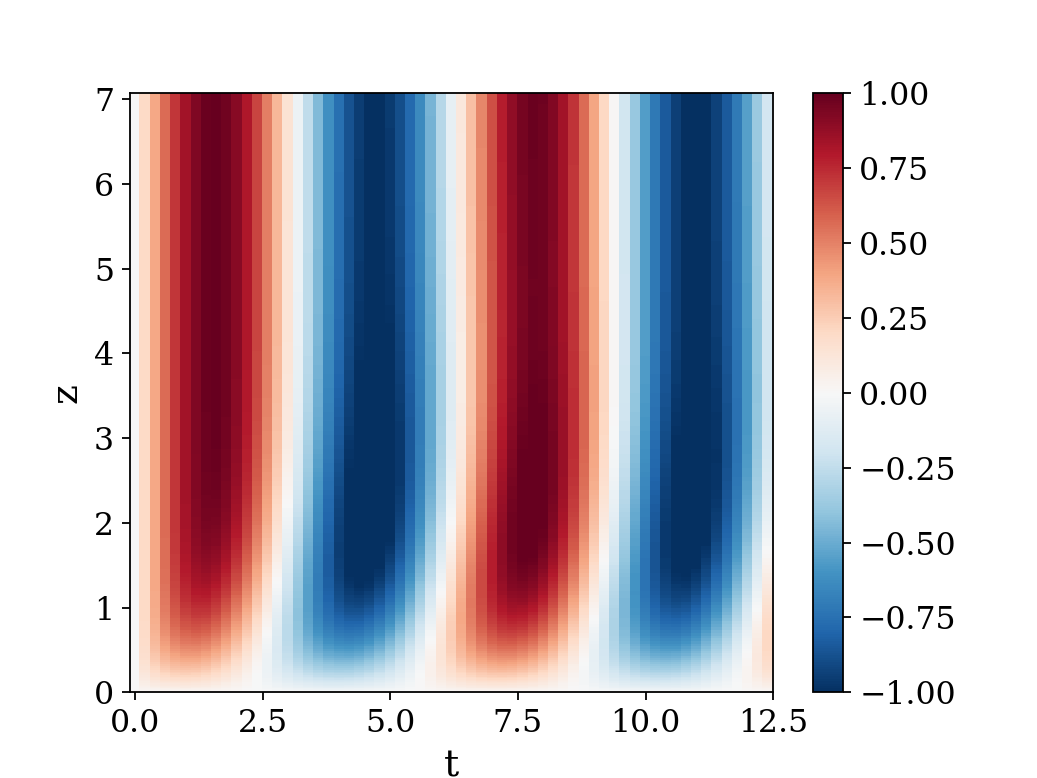

In [49]:
plt.figure()
plt.pcolormesh(tmesh.T, zmesh.T, u_array.T, cmap='RdBu_r',vmin=-1, vmax=1)
plt.axis(pad_limits(tmesh, zmesh))
plt.colorbar()
plt.ylabel('z')
plt.xlabel('t')

plt.show()

In [38]:
u_array.shape, z.shape, len(t_list)

((63, 200), (200,), 63)

<IPython.core.display.Javascript object>


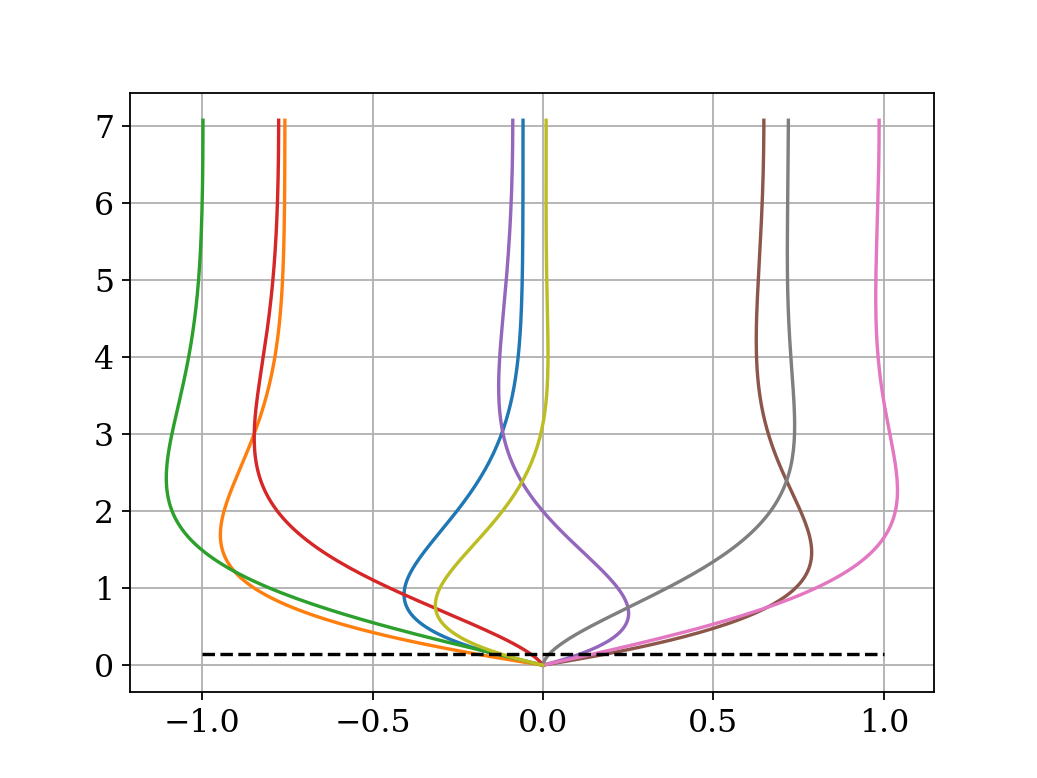

In [50]:
def get_ind(t_array, val):
    
    dt = np.abs(t_array-val)
    return np.where(dt==np.min(dt))[0][0]

z_ = z/delta

plt.figure()
# plt.plot(u_array[0,:], z, 'k:')
plt.plot(u_array[get_ind(t_array, 1.00*np.pi),:], z_)
plt.plot(u_array[get_ind(t_array, 1.25*np.pi),:], z_)
plt.plot(u_array[get_ind(t_array, 1.50*np.pi),:], z_)
plt.plot(u_array[get_ind(t_array, 1.75*np.pi),:], z_)
plt.plot(u_array[get_ind(t_array, 2.00*np.pi),:], z_)
plt.plot(u_array[get_ind(t_array, 2.25*np.pi),:], z_)
plt.plot(u_array[get_ind(t_array, 2.50*np.pi),:], z_)
plt.plot(u_array[get_ind(t_array, 2.75*np.pi),:], z_)
plt.plot(u_array[get_ind(t_array, 3.00*np.pi),:], z_)
# plt.plot(u_array[-1,:],z, 'k')

plt.plot([-1, 1], [delta, delta], 'k--')
plt.grid()